In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
taxi = pd.read_csv('CSV/taxi.xls')

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

В загруженных данных нет пропусков, что очень радует. Посмотрим на наши данные и пройдемся по каждому столбцу.

In [4]:
taxi.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


Насколько я понимаю, предсказывать будем ответ водителя? столбец driver_response. Посмотрим на него:

In [5]:
taxi['driver_response'].unique()

array([0, 1], dtype=int64)

Значения допустимые, признак категориальный, учтем это в дальнейшем, посмотрим на столбец offer_gk:

In [6]:
taxi['offer_gk'].nunique()

100000

Это какой то уникальный ключ, вряд ли он нам нужен, удалим его:

In [7]:
taxi = taxi.drop('offer_gk', axis=1)
taxi

,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,2,2442,27360,55.961246,37.413497,55.966694,37.415754,17.378,29.817,Economy,private,0
99996,0,1,2442,381960,55.961246,37.413497,55.964892,37.413543,7.751,12.683,Economy,private,0
99997,1,20,2442,627126,55.961315,37.413497,55.962203,37.416373,46.983,46.217,Standard,private,0
99998,6,21,2442,140623,55.961354,37.413864,55.964892,37.413543,50.029,51.100,Economy,private,0


Проверим столбцы weekday_key и hour_key на допустимость значений, признаки категориальные, создадим на их основе dummy-переменные. Также можно создать признаки выходной ли день для дней недели и период дня для времени.

In [8]:
sorted(taxi['weekday_key'].unique())

[0, 1, 2, 3, 4, 5, 6]

In [9]:
sorted(taxi['hour_key'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

Дни нелели и часы лежат в допустимом диапазоне, некорректных данных нет. Перейдем к созданию новых признаков:

In [10]:
part_of_day = {0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:2, 13:2, 14:2, 
                  15:2, 16:2, 17:3, 18:3, 19:3, 20:3, 21:3, 22:3, 23:3}
is_weekend = {0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1}

taxi['part_of_day'] = taxi['hour_key'].map(part_of_day)
taxi['is_weekend'] = taxi['weekday_key'].map(is_weekend)

taxi = pd.concat([taxi, pd.get_dummies(taxi['hour_key'], prefix='hour')], axis=1)
taxi = taxi.drop('hour_key', axis=1)

taxi = pd.concat([taxi, pd.get_dummies(taxi['part_of_day'], prefix='part_day')], axis=1)
taxi = taxi.drop('part_of_day', axis=1)

taxi = pd.concat([taxi, pd.get_dummies(taxi['weekday_key'], prefix='weekday')], axis=1)
taxi = taxi.drop('weekday_key', axis=1)

taxi

,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2442,27360,55.961246,37.413497,55.966694,37.415754,17.378,29.817,Economy,private,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
99996,2442,381960,55.961246,37.413497,55.964892,37.413543,7.751,12.683,Economy,private,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
99997,2442,627126,55.961315,37.413497,55.962203,37.416373,46.983,46.217,Standard,private,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
99998,2442,140623,55.961354,37.413864,55.964892,37.413543,50.029,51.100,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


Поле order_gk:

In [11]:
taxi['order_gk'].nunique()

81435

Ключ заказа оказался не таким уж уникальным, поизучаем его подробнее:

In [12]:
taxi['order_gk'].value_counts()

853342    14
714527    13
761031    13
828548    12
180487    12
          ..
529767     1
361705     1
57063      1
782999     1
786432     1
Name: order_gk, Length: 81435, dtype: int64

In [13]:
taxi[taxi.order_gk == 180487]

,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
13456,2291,180487,55.962324,37.407116,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
16729,4297,180487,55.965300,37.430250,55.964892,37.413543,-1.0,-1.0,Economy,business,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
25829,1793,180487,55.964912,37.417926,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
27103,2381,180487,55.961392,37.413817,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
27824,1060,180487,55.961859,37.407126,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
31358,6762,180487,55.964892,37.413543,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
38802,1421,180487,55.961179,37.413284,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
41544,1537,180487,55.962323,37.407114,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
60492,975,180487,55.960537,37.413353,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
69590,4490,180487,55.961926,37.409716,55.964892,37.413543,-1.0,-1.0,Economy,business,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


Просмотрев несколько заказов, которым соответствует несколько строк, я заметила, что они отличаются только местонахождением водителя, остальные признаки одинаковые. Пока запомню этот момент, потом к нему вернусь.

Признак координаты. Здесь мне сложно что-то сказать, по идее одна координата не имеет смысл, имеет смысл две координаты (широта и долгота). Я хочу удалить столбцы с координатами. В реальной модели я бы попробовала заменить признак координаты, например, на районы города; то есть 4 столбца с координатами заменила бы на 2 категориальных столбца (место водителя и место нахождения заказчика). Еще можно добавить признак расстояние от водителя до места заказа. Так как вычислить расстояние по координатам не так просто, я буду вычислять как расстояние между двумя точками (если это город, то его можно условно представить как плоскость, не смотря на то, что Земля круглая)), получится некое условное число. Для очистки совести я проверю зависимость целевой переменной от столбцов с координатами.

In [14]:
taxi[['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude', 'driver_response']].corr()

,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,driver_response
driver_latitude,1.000000,0.986198,0.031568,-0.036470,-0.051948
driver_longitude,0.986198,1.000000,-0.003323,0.017067,-0.019828
origin_order_latitude,0.031568,-0.003323,1.000000,0.856676,-0.049377
origin_order_longitude,-0.036470,0.017067,0.856676,1.000000,0.053248
driver_response,-0.051948,-0.019828,-0.049377,0.053248,1.000000


Корреляции c целевым признаком нет.

In [15]:
taxi['distance_to_origin'] = taxi.apply(lambda row: ((row.driver_latitude-row.origin_order_latitude)**2
      + (row.driver_longitude-row.origin_order_longitude)**2)**0.5*1000, axis=1)

In [16]:
taxi = taxi.drop(['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis=1)
taxi

,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin
0,6080,174182,-1.000,-1.000,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,20.890101
1,6080,358774,18.802,25.217,Standard,private,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,50.596707
2,6080,866260,6.747,9.800,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6.442189
3,6080,163522,-1.000,-1.000,Economy,private,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,9.697378
4,6080,506710,12.383,19.250,Economy,private,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,10.693755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2442,27360,17.378,29.817,Economy,private,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.897012
99996,2442,381960,7.751,12.683,Economy,private,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.646290
99997,2442,627126,46.983,46.217,Standard,private,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,3.009970
99998,2442,140623,50.029,51.100,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,3.552532


Проверим снова заказ с несколькими строками:

In [17]:
taxi[taxi.order_gk == 853342]

,driver_gk,order_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin
23218,4339,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,9.678719
23484,801,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,8.840839
23651,2236,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.001000
24326,4600,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.002236
24651,4804,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,8.391631
24926,4100,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,6.194348
25672,1793,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2.355506
26857,668,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2.164548
27009,2381,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,6.947579
27502,1060,853342,7.718,16.7,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0.463087


Теперь строки отличаются колонкой distance_to_origin, сам номер заказа можно удалить.

In [18]:
taxi = taxi.drop('order_gk', axis=1)
taxi

,driver_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin
0,6080,-1.000,-1.000,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,20.890101
1,6080,18.802,25.217,Standard,private,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,50.596707
2,6080,6.747,9.800,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6.442189
3,6080,-1.000,-1.000,Economy,private,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,9.697378
4,6080,12.383,19.250,Economy,private,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,10.693755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2442,17.378,29.817,Economy,private,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.897012
99996,2442,7.751,12.683,Economy,private,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.646290
99997,2442,46.983,46.217,Standard,private,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,3.009970
99998,2442,50.029,51.100,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,3.552532


Уже отсюда видно, что есть расстояния и длительность отрицательные, скорее всего, это из-за рассчетов, в которых забыли взять расстояние по модулю, возьмем эти столбцы по модулю и проверим их на выбросы.

In [19]:
taxi['distance_km'] = taxi['distance_km'].apply(lambda x: abs(x))
taxi['duration_min'] = taxi['duration_min'].apply(lambda x: abs(x))
taxi.head()

,driver_gk,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin
0,6080,1.000,1.000,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,20.890101
1,6080,18.802,25.217,Standard,private,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,50.596707
2,6080,6.747,9.800,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6.442189
3,6080,1.000,1.000,Economy,private,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,9.697378
4,6080,12.383,19.250,Economy,private,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,10.693755


<AxesSubplot:>

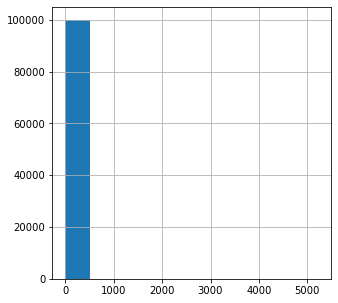

In [21]:
plt.rcParams['figure.figsize'] = (5,5)
taxi['distance_km'].hist()

In [22]:
taxi['distance_km'].describe()

count    100000.000000
mean         18.917658
std          40.890861
min           0.000000
25%           1.000000
50%          10.411500
75%          30.665250
max        5234.283000
Name: distance_km, dtype: float64

Очевидно, тут какой то непорядок. Во-первых, минимальное расстояние равно 0, какой в этом смысл, а во-вторых, верхняя граница очень высокая. Рассчитаем верхнюю границу выбросов межквартильным методом.

In [23]:
perc25 = taxi['distance_km'].quantile(0.25)
perc75 = taxi['distance_km'].quantile(0.75)
IQR = perc75 - perc25
perc75 + 1.5*IQR

75.16312500000001

In [24]:
len(taxi[(taxi.distance_km > 76)|(taxi.distance_km == 0)])

1113

In [25]:
1113*100/100000

1.113

Выбросов около 1%, смело их удаляем:

<AxesSubplot:>

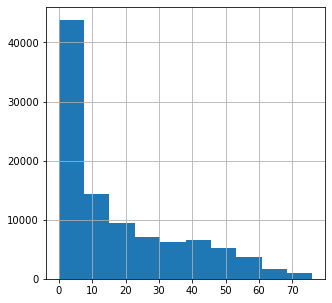

In [26]:
taxi = taxi[(taxi.distance_km < 76)&(taxi.distance_km > 0)]
plt.rcParams['figure.figsize'] = (5,5)
taxi['distance_km'].hist()

По графику видно, что в основном люди делают заказ на небольшие расстояния (до 10 км). Теперь проверим корреляцию между рсстоянием и длительностью в минутах, есть подозрение, что корреляция будет очень большой.

In [27]:
taxi[['distance_km', 'duration_min']].corr()

,distance_km,duration_min
distance_km,1.000000,0.957477
duration_min,0.957477,1.000000


Так и есть. Удалим столбец с длительностью, чтобы не мешал:

In [28]:
taxi = taxi.drop('duration_min', axis=1)
taxi

,driver_gk,distance_km,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin
0,6080,1.000,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,20.890101
1,6080,18.802,Standard,private,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,50.596707
2,6080,6.747,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6.442189
3,6080,1.000,Economy,private,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,9.697378
4,6080,12.383,Economy,private,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,10.693755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2442,17.378,Economy,private,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.897012
99996,2442,7.751,Economy,private,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.646290
99997,2442,46.983,Standard,private,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,3.009970
99998,2442,50.029,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,3.552532


Столбец driver_gk:

In [29]:
taxi['driver_gk'].value_counts()

1421    2970
1060    2749
1126    2305
4490    1755
2442    1560
        ... 
2844      52
689       52
1978      52
854       51
3242      50
Name: driver_gk, Length: 439, dtype: int64

In [30]:
taxi['driver_gk'].nunique()

439

Признак driver_gk категориальный, но разных значений очень много, с этим надо что-то делать. Можно оставить "топовых" водителей, то есть тех, кто совершил больше 1000 поездок, например, остальных поместить в others. Я же решила сделать на основе этого столбца 2 новых признака: количество поездок и процент положительных исходов для каждого водителя. 

In [31]:
taxi['driver_count'] = taxi['driver_gk'].map(taxi.groupby('driver_gk').size())
taxi['driver_positive'] = taxi['driver_gk'].map(taxi.groupby('driver_gk')['driver_response'].sum()*100/taxi.groupby('driver_gk').size())
taxi = taxi.drop('driver_gk', axis=1)
taxi

,distance_km,offer_class_group,ride_type_desc,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_0,part_day_1,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin,driver_count,driver_positive
0,1.000,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,20.890101,278,57.913669
1,18.802,Standard,private,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,50.596707,278,57.913669
2,6.747,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6.442189,278,57.913669
3,1.000,Economy,private,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,9.697378,278,57.913669
4,12.383,Economy,private,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,10.693755,278,57.913669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,17.378,Economy,private,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,5.897012,1560,5.320513
99996,7.751,Economy,private,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.646290,1560,5.320513
99997,46.983,Standard,private,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,3.009970,1560,5.320513
99998,50.029,Economy,private,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,3.552532,1560,5.320513


Проверим столбец offer_class_group:

In [32]:
taxi['offer_class_group'].value_counts()

Economy     47742
Standard    46812
Premium      1757
Delivery     1286
Kids          584
XL            448
VIP           221
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

Честно говоря, я думала, что классов меньше, Economy и Standard, тогда можно было бы этот столбец превратить в ординальный признак (Economy < Standard < Premium), а так категориальный.

Проверим признак ride_type_desc

In [34]:
taxi['ride_type_desc'].value_counts()

private      90099
business      8528
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

Этот признак также категориальный. Закодируем эти категориальные признаки в dummy-переменные:

In [35]:
taxi = pd.concat([taxi, pd.get_dummies(taxi['offer_class_group'])], axis=1)
taxi = taxi.drop('offer_class_group', axis=1)

taxi = pd.concat([taxi, pd.get_dummies(taxi['ride_type_desc'])], axis=1)
taxi = taxi.drop('ride_type_desc', axis=1)
taxi

,distance_km,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,...,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin,driver_count,driver_positive,Delivery,Economy,Kids,Premium,Standard,Test,VIP,VIP+,XL,SMB,affiliate,business,private
0,1.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,20.890101,278,57.913669,0,1,0,0,0,0,0,0,0,0,0,0,1
1,18.802,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,50.596707,278,57.913669,0,0,0,0,1,0,0,0,0,0,0,0,1
2,6.747,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,6.442189,278,57.913669,0,1,0,0,0,0,0,0,0,0,0,0,1
3,1.000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,9.697378,278,57.913669,0,1,0,0,0,0,0,0,0,0,0,0,1
4,12.383,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,10.693755,278,57.913669,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,17.378,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,5.897012,1560,5.320513,0,1,0,0,0,0,0,0,0,0,0,0,1
99996,7.751,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.646290,1560,5.320513,0,1,0,0,0,0,0,0,0,0,0,0,1
99997,46.983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,3.009970,1560,5.320513,0,0,0,0,1,0,0,0,0,0,0,0,1
99998,50.029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,3.552532,1560,5.320513,0,1,0,0,0,0,0,0,0,0,0,0,1


Проверим наши данные:

In [36]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98887 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   distance_km         98887 non-null  float64
 1   driver_response     98887 non-null  int64  
 2   is_weekend          98887 non-null  int64  
 3   hour_0              98887 non-null  uint8  
 4   hour_1              98887 non-null  uint8  
 5   hour_2              98887 non-null  uint8  
 6   hour_3              98887 non-null  uint8  
 7   hour_4              98887 non-null  uint8  
 8   hour_5              98887 non-null  uint8  
 9   hour_6              98887 non-null  uint8  
 10  hour_7              98887 non-null  uint8  
 11  hour_8              98887 non-null  uint8  
 12  hour_9              98887 non-null  uint8  
 13  hour_10             98887 non-null  uint8  
 14  hour_11             98887 non-null  uint8  
 15  hour_12             98887 non-null  uint8  
 16  hour

Все столбцы числовые, пропусков нет. Проверим корреляцию признаков:

In [37]:
taxi_corr = taxi.corr()
taxi_corr

,distance_km,driver_response,is_weekend,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,...,part_day_2,part_day_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin,driver_count,driver_positive,Delivery,Economy,Kids,Premium,Standard,Test,VIP,VIP+,XL,SMB,affiliate,business,private
distance_km,1.000000,-0.312684,-0.016588,0.102466,0.059890,0.038972,0.025516,0.068567,0.052020,0.035632,-0.026515,-0.054065,-0.059897,-0.053342,-0.050596,-0.046723,-0.043074,-0.050985,-0.048448,-0.044485,-0.048319,-0.048159,-0.014788,-0.001711,0.043159,...,-0.113565,0.039829,0.094654,0.040181,-0.043286,-0.042270,-0.031689,-0.025990,0.006529,-0.025804,0.298548,-0.399583,-0.037544,0.077276,-0.013703,-0.064305,-0.046790,-0.008019,-0.030065,-0.012669,0.003782,-0.004444,-0.042479,-0.267815,0.271599
driver_response,-0.312684,1.000000,-0.002718,-0.114344,-0.046778,-0.030015,-0.033986,-0.069365,-0.056634,-0.025007,0.020566,0.038410,0.074445,0.083353,0.080362,0.079946,0.074577,0.068418,0.058009,0.043018,0.035482,0.016453,-0.001037,-0.007762,-0.040029,...,0.155377,-0.090787,-0.059588,-0.025693,0.029420,0.048948,0.015565,-0.015649,0.013510,0.036512,-0.465600,0.694604,0.042189,-0.103719,0.053673,0.074945,0.059278,0.004600,0.026024,0.013780,0.028778,0.005518,0.000117,0.061065,-0.060631
is_weekend,-0.016588,-0.002718,1.000000,-0.016208,0.014899,0.006143,0.012547,-0.007220,0.002076,0.007385,-0.010316,-0.019794,-0.012687,-0.002495,-0.000558,0.011599,0.008148,0.011684,0.001298,0.011347,0.017946,0.000388,-0.016227,-0.008663,-0.005044,...,0.021184,-0.003279,-0.298732,-0.282886,-0.280880,-0.264835,-0.285877,0.670229,0.585616,-0.005134,-0.071812,0.037057,-0.003366,0.009131,0.008322,-0.003000,-0.014032,0.000518,0.023021,0.007343,0.020331,-0.002796,0.012573,-0.034721,0.032340
hour_0,0.102466,-0.114344,-0.016208,1.000000,-0.050144,-0.040339,-0.035417,-0.039602,-0.035966,-0.033939,-0.042463,-0.051052,-0.049237,-0.045584,-0.045865,-0.048157,-0.049392,-0.051285,-0.056051,-0.057717,-0.061093,-0.066516,-0.069399,-0.070408,-0.075122,...,-0.128190,-0.246846,0.024091,0.086872,-0.027412,-0.029875,-0.033078,-0.024060,0.004922,-0.009316,0.076042,-0.143509,-0.028686,-0.002561,-0.017810,-0.010108,0.015420,-0.002389,-0.009116,-0.002168,0.000294,-0.002931,-0.005795,-0.007820,0.008879
hour_1,0.059890,-0.046778,0.014899,-0.050144,1.000000,-0.028679,-0.025180,-0.028155,-0.025571,-0.024129,-0.030189,-0.036296,-0.035005,-0.032409,-0.032608,-0.034238,-0.035115,-0.036461,-0.039850,-0.041035,-0.043435,-0.047290,-0.049340,-0.050057,-0.053408,...,-0.091138,-0.175497,0.023349,0.023609,-0.026659,-0.011770,-0.030997,-0.013670,0.034562,-0.001645,0.027685,-0.060491,-0.019715,0.015937,-0.012381,-0.004401,-0.009711,-0.001698,-0.001888,-0.003234,0.012041,-0.000696,0.005004,0.006410,-0.007113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XL,0.003782,0.028778,0.020331,0.000294,0.012041,0.003953,0.013988,0.002328,0.022568,0.005750,-0.002094,-0.005658,-0.006626,-0.008870,-0.007161,-0.006229,-0.008358,-0.004130,0.000667,-0.005954,-0.001045,-0.003478,-0.004701,0.003392,0.004490,...,-0.011407,0.001918,0.011476,-0.012294,-0.007992,-0.008981,-0.011790,-0.007059,0.034499,-0.002026,-0.044087,0.033457,-0.007744,-0.065178,-0.005200,-0.009073,-0.063962,-0.000607,-0.003193,-0.001155,1.000000,-0.001287,-0.003214,-0.020725,0.021069
SMB,-0.004444,0.005518,-0.002796,-0.002931,-0.000696,-0.002899,-0.002545,-0.002846,-0.002584,0.001777,-0.003051,-0.003669,0.002377,-0.003276,-0.000135,-0.003460,0.005298,0.004857,-0.001404,0.003516,0.005315,-0.000281,-0.004987,0.001361,0.000674,...,0.004329,0.003523,-0.007811,-0.002677,-0.002600,0.011261,0.006574,0.002751,-0.006690,-0.000751,0.000701,0.001808,0.002488,0.009144,-0.0014

Таблица большая, мало информативная, построим график:

<AxesSubplot:>

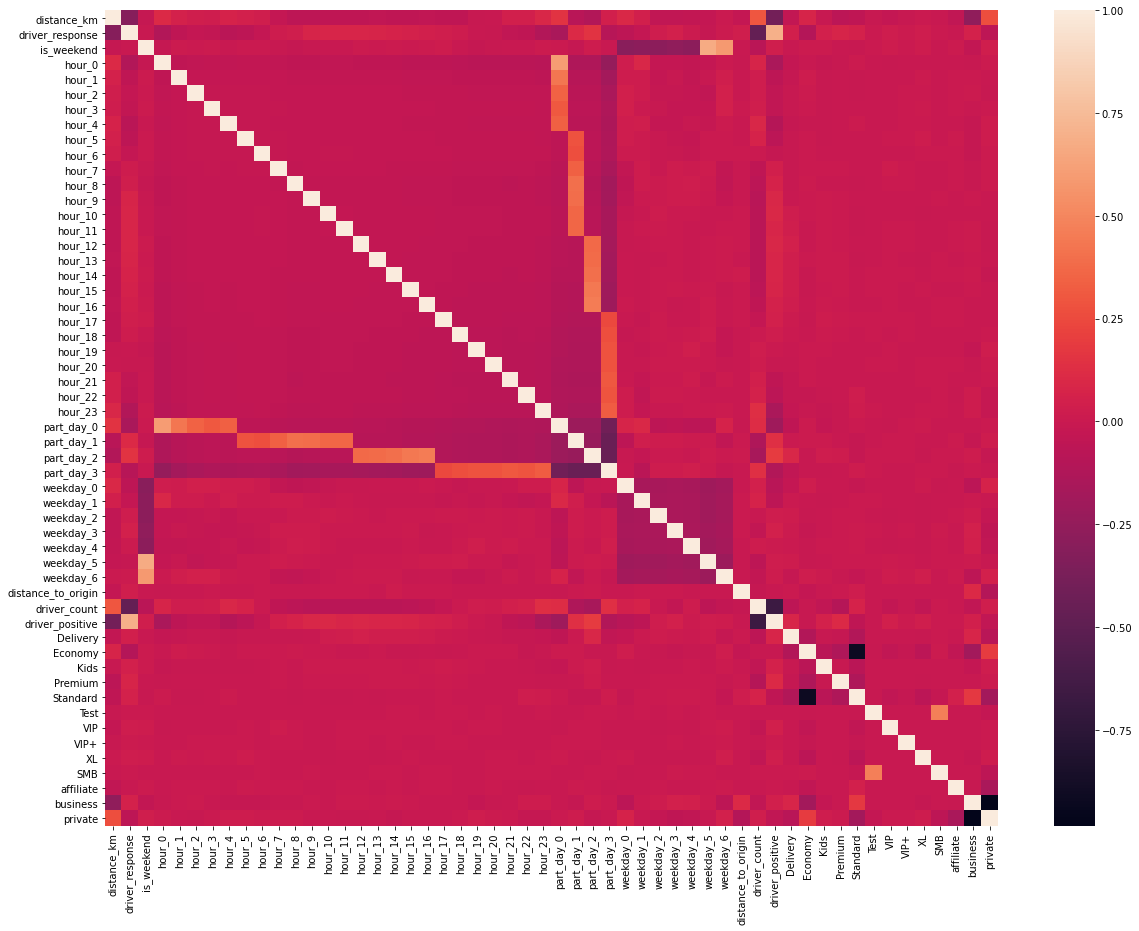

In [38]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(taxi_corr)

По графику видно значительную корреляцию между признаками business и private, Economy и Standard, также можно проверить признаки driver_count и driver_positive.

In [39]:
taxi[['business', 'private']].corr()

,business,private
business,1.000000,-0.983678
private,-0.983678,1.000000


In [40]:
taxi[['Economy', 'Standard']].corr()

,Economy,Standard
Economy,1.000000,-0.916036
Standard,-0.916036,1.000000


In [41]:
taxi[['driver_count', 'driver_positive']].corr()

,driver_count,driver_positive
driver_count,1.000000,-0.670311
driver_positive,-0.670311,1.000000


Во избежания мультиколинеарности (фиктивной ловушки) удалим по одной dummy-переменной из каждого набора. Для наборов offer_class_group и ride_type_desc удаляемым столбцом будет один из сильноскоррелированных (убьем двух зайцев). Столбцы driver_count и driver_positive оказались не сильно скорелированными, их оставим.

In [42]:
taxi = taxi.drop(['hour_0', 'part_day_0', 'weekday_0', 'private', 'Standard'], axis=1)
taxi

,distance_km,driver_response,is_weekend,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,part_day_1,part_day_2,part_day_3,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,distance_to_origin,driver_count,driver_positive,Delivery,Economy,Kids,Premium,Test,VIP,VIP+,XL,SMB,affiliate,business
0,1.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,20.890101,278,57.913669,0,1,0,0,0,0,0,0,0,0,0
1,18.802,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,50.596707,278,57.913669,0,0,0,0,0,0,0,0,0,0,0
2,6.747,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,6.442189,278,57.913669,0,1,0,0,0,0,0,0,0,0,0
3,1.000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,9.697378,278,57.913669,0,1,0,0,0,0,0,0,0,0,0
4,12.383,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,10.693755,278,57.913669,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,17.378,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.897012,1560,5.320513,0,1,0,0,0,0,0,0,0,0,0
99996,7.751,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.646290,1560,5.320513,0,1,0,0,0,0,0,0,0,0,0
99997,46.983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,3.009970,1560,5.320513,0,0,0,0,0,0,0,0,0,0,0
99998,50.029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,3.552532,1560,5.320513,0,1,0,0,0,0,0,0,0,0,0


In [43]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98887 entries, 0 to 99999
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   distance_km         98887 non-null  float64
 1   driver_response     98887 non-null  int64  
 2   is_weekend          98887 non-null  int64  
 3   hour_1              98887 non-null  uint8  
 4   hour_2              98887 non-null  uint8  
 5   hour_3              98887 non-null  uint8  
 6   hour_4              98887 non-null  uint8  
 7   hour_5              98887 non-null  uint8  
 8   hour_6              98887 non-null  uint8  
 9   hour_7              98887 non-null  uint8  
 10  hour_8              98887 non-null  uint8  
 11  hour_9              98887 non-null  uint8  
 12  hour_10             98887 non-null  uint8  
 13  hour_11             98887 non-null  uint8  
 14  hour_12             98887 non-null  uint8  
 15  hour_13             98887 non-null  uint8  
 16  hour

Переходим к обучению модели. Поделим данные для обучения модели и тестовые:

In [44]:
RANDOM_SEED = 42

In [45]:
X = taxi.drop(['driver_response'], axis=1)
y = taxi['driver_response']

In [46]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

Попробуем случайный лес:

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
forest = RandomForestRegressor(n_estimators=100)

In [51]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [52]:
y_pred_forest = forest.predict(X_test)
y_pred_forest

array([1.        , 0.01      , 0.08      , ..., 0.04833333, 0.93      ,
       0.01      ])

Вычислим метрики. Вспомним, что значения пердсказания категориальный признак, приблизим значения к 0 или 1:

In [53]:
y_pred_forest = np.round(y_pred_forest).astype('int')
np.unique(y_pred_forest)

array([0, 1])

In [54]:
from sklearn import metrics

In [55]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_forest))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_forest))

MAE: 0.16616778577784969
MSE: 0.16616778577784969


Посмотрим самые важные признаки для модели:

<AxesSubplot:>

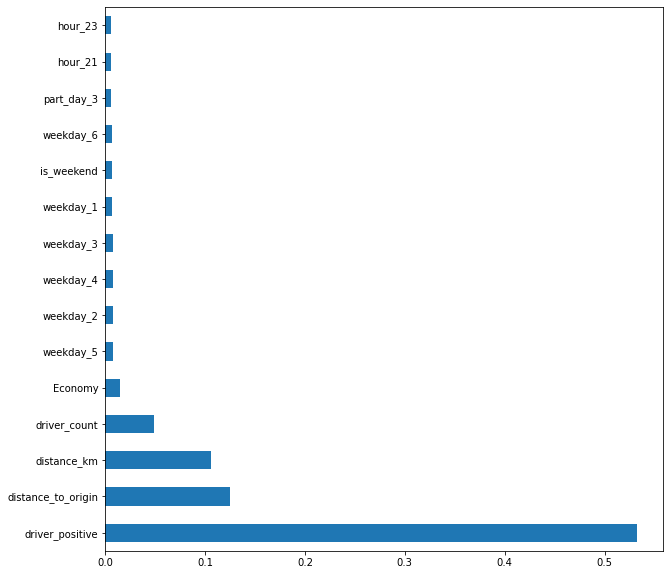

In [56]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

По графику мы видим, что наибольший вес в предсказании имеет "отзывчивость" водителя, то есть количество его положительных ответов (в процентах). Также имеет вес расстояние от водителя до заказа, расстояние заказа и количество поездок водителя.

Линейная регрессия:

In [57]:
from sklearn.linear_model import LinearRegression

In [58]:
liner = LinearRegression() #Обозначаем, что наша модель - линейная регрессия
liner.fit(X_train,y_train) #обучаем модель на обучающих данных

LinearRegression()

In [59]:
y_pred_liner = liner.predict(X_test)
y_pred_liner

array([0.89361088, 0.38192668, 0.07529749, ..., 0.11492167, 0.9956559 ,
       0.12029292])

Метрики линейной регрессии:

In [60]:
y_pred_liner = np.round(y_pred_liner).astype('int')
np.unique(y_pred_liner)

array([0, 1, 2])

2 - это нехорошо. Заменим 2 на 1.

In [61]:
y_pred_liner[y_pred_liner==2] = 1
np.unique(y_pred_liner)

array([0, 1])

In [63]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_liner))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_liner))

MAE: 0.17466224415500364
MSE: 0.17466224415500364


<AxesSubplot:>

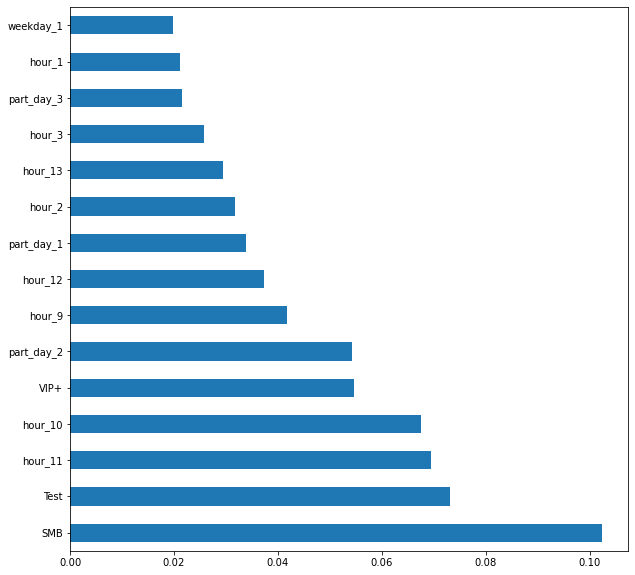

In [64]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(liner.coef_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

В линейной модели мы видим, что веса распределены более равномерно и нет явного лидера. Среди лидеров нет весов, связанных с водителем. По метрикам линейная модель хуже. Итог: если надо предсказать результат по водителю, который есть в базе, то я бы применила модель "Случайный лес", для новых водителей - линейную регрессию.